<a href="https://colab.research.google.com/github/sayan0506/Synthetic-Image-generation-using-VAE-/blob/main/Implementing_VAE_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Modules

Importing nercessary modules, here we will implement the VAE using the tensorflow backend from scratch

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


# Defining Parameters

In [ ]:
# parameters of the neural network

# defining the learning rate, epochs, batch_size(no. of datapoints in each mini_batch) for optimization
learning_rate = 0.001
epochs = 30000
batch_size = 32

# network parameters
# we have image size 28*28
# we will flatten the images as 784 features of input to the neural network
image_dimension = 784
# dimension of the hidden layer, whhich will be same shape for both encoder and decoder layer
hidden_dimension = 512

# inititally we are taking latent space dimension as 2
latent_space_dimension = 2

# here we are defining the xavier-initialization parameters, which helps to prevent the error due to vanishing and exploding gradients for deep networks
def xavier(in_shape):
  # here we are restricting the standard deviations of the distribution of the weights in a certain limit which is 1/sqrt(n/2)
  # where n is the number of neurons in the layer
  # tf.random.normal() creates a matrix whose elements are sampled from a normal distribution having stad. as mentioned
  val = tf.random.normal(shape = in_shape, stddev  = 1./tf.sqrt(in_shape[0]/2.))
  # use tf.random.normal() instead of tf.random_normal(), else it will throw module not found error
  tf.random_normal_initializer()
  return val


Here we are defining the weights and bias dictionaries corresponding to the VAE

In [13]:
# weight dictionary corresponding to the 5 layers
# note if we take tf.Variable(), we have to initialize it, else 
# in each layer the regression equation is [z = transpose(W) + b]
weight = {"weight_matrix_encoder_hidden": tf.Variable(xavier([image_dimension, hidden_dimension])),
          "weight_matrix_mean_hidden": tf.Variable(xavier([hidden_dimension, latent_space_dimension])),
          "weight_matrix_std_hidden": tf.Variable(xavier([hidden_dimension, latent_space_dimension])),
          "weight_matrix_decoder_hidden": tf.Variable(xavier([latent_space_dimension, hidden_dimension])),
          "weight_matrix_decoder_output": tf.Variable(xavier([hidden_dimension, image_dimension]))
          }

# defining the bias dictionary
bias = {"bias_matrix_encoder_hidden": tf.Variable(xavier([hidden_dimension])),
        "bias_matrix_mean_hidden": tf.Variable(xavier([latent_space_dimension])),
        "bias_matrix_std_hidden": tf.Variable(xavier([latent_space_dimension])),
        "bias_matrix_decoder_hidden": tf.Variable(xavier([hidden_dimension])),
        "bias_matrix_decoder_output": tf.Variable(xavier([image_dimension]))
        }

# Building the Computational Graph of the Variational Autoencoder

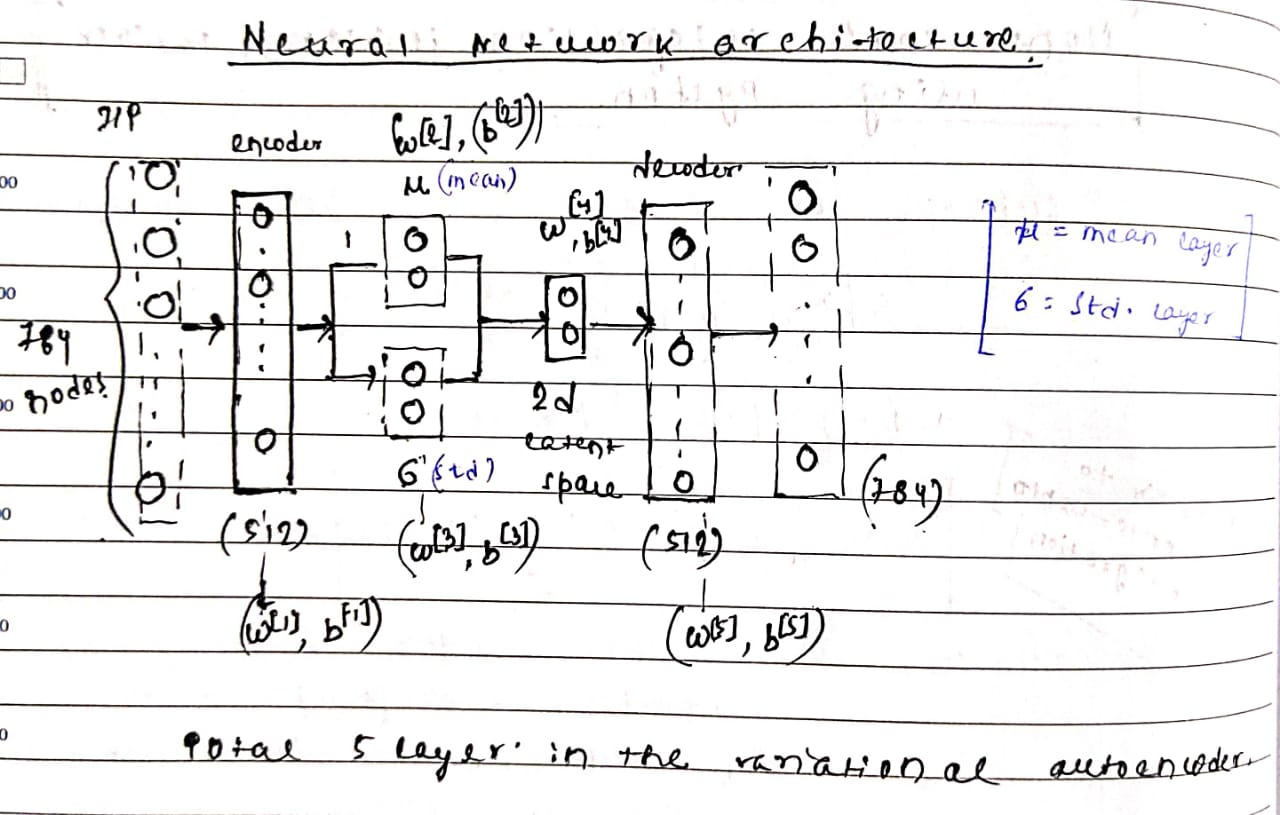

* The placeholder can take dynamic data without need of any initialization can take data of shape [None, size]
* Sometimes due to version error we found "module not found error" in tf.placeholder, so we disable the v2 behaviour from the [solution link](https://stackoverflow.com/questions/56561734/runtimeerror-tf-placeholder-is-not-compatible-with-eager-execution)

In [9]:

# defining the Encoder section

# defining the input layer
image_x = tf.placeholder(shape = [None, image_dimension], dtype=tf.float32)

## encoder layer
encoder_layer = tf.add(tf.matmul(image_x, weight["weight_matrix_encoder_hidden"]), bias["bias_matrix_encoder_hidden"])
# activating the encoder layer with tanh activation
encoder_layer = tf.nn.tanh(encoder_layer)

# mean layer
mean_layer = tf.add(tf.matmul(encoder_layer, weight["weight_matrix_mean_hidden"]), bias["bias_matrix_mean_hidden"])

# standard deviation hidden layer
std_layer = tf.add(tf.matmul(encoder_layer, weight["weight_matrix_std_hidden"]), bias["bias_matrix_std_hidden"])

## Reparameterization trick

We need to do reparameterization for executing gradients inside the expectation variable correspond to the reconstruction loss of the **variational lower bound**, where we do a trasnformation for the latent space samples

>**z = mean_encoder_section + epsilon * sqrt(covariance matrix correspond to encoder section)** 

* Here **epsilon** is the matrix which contains the random sample from the normal distribution **N~(0,1)** [That is the distribution we choose so that latent space can maintain it, which i regularized by the KL divergence term)

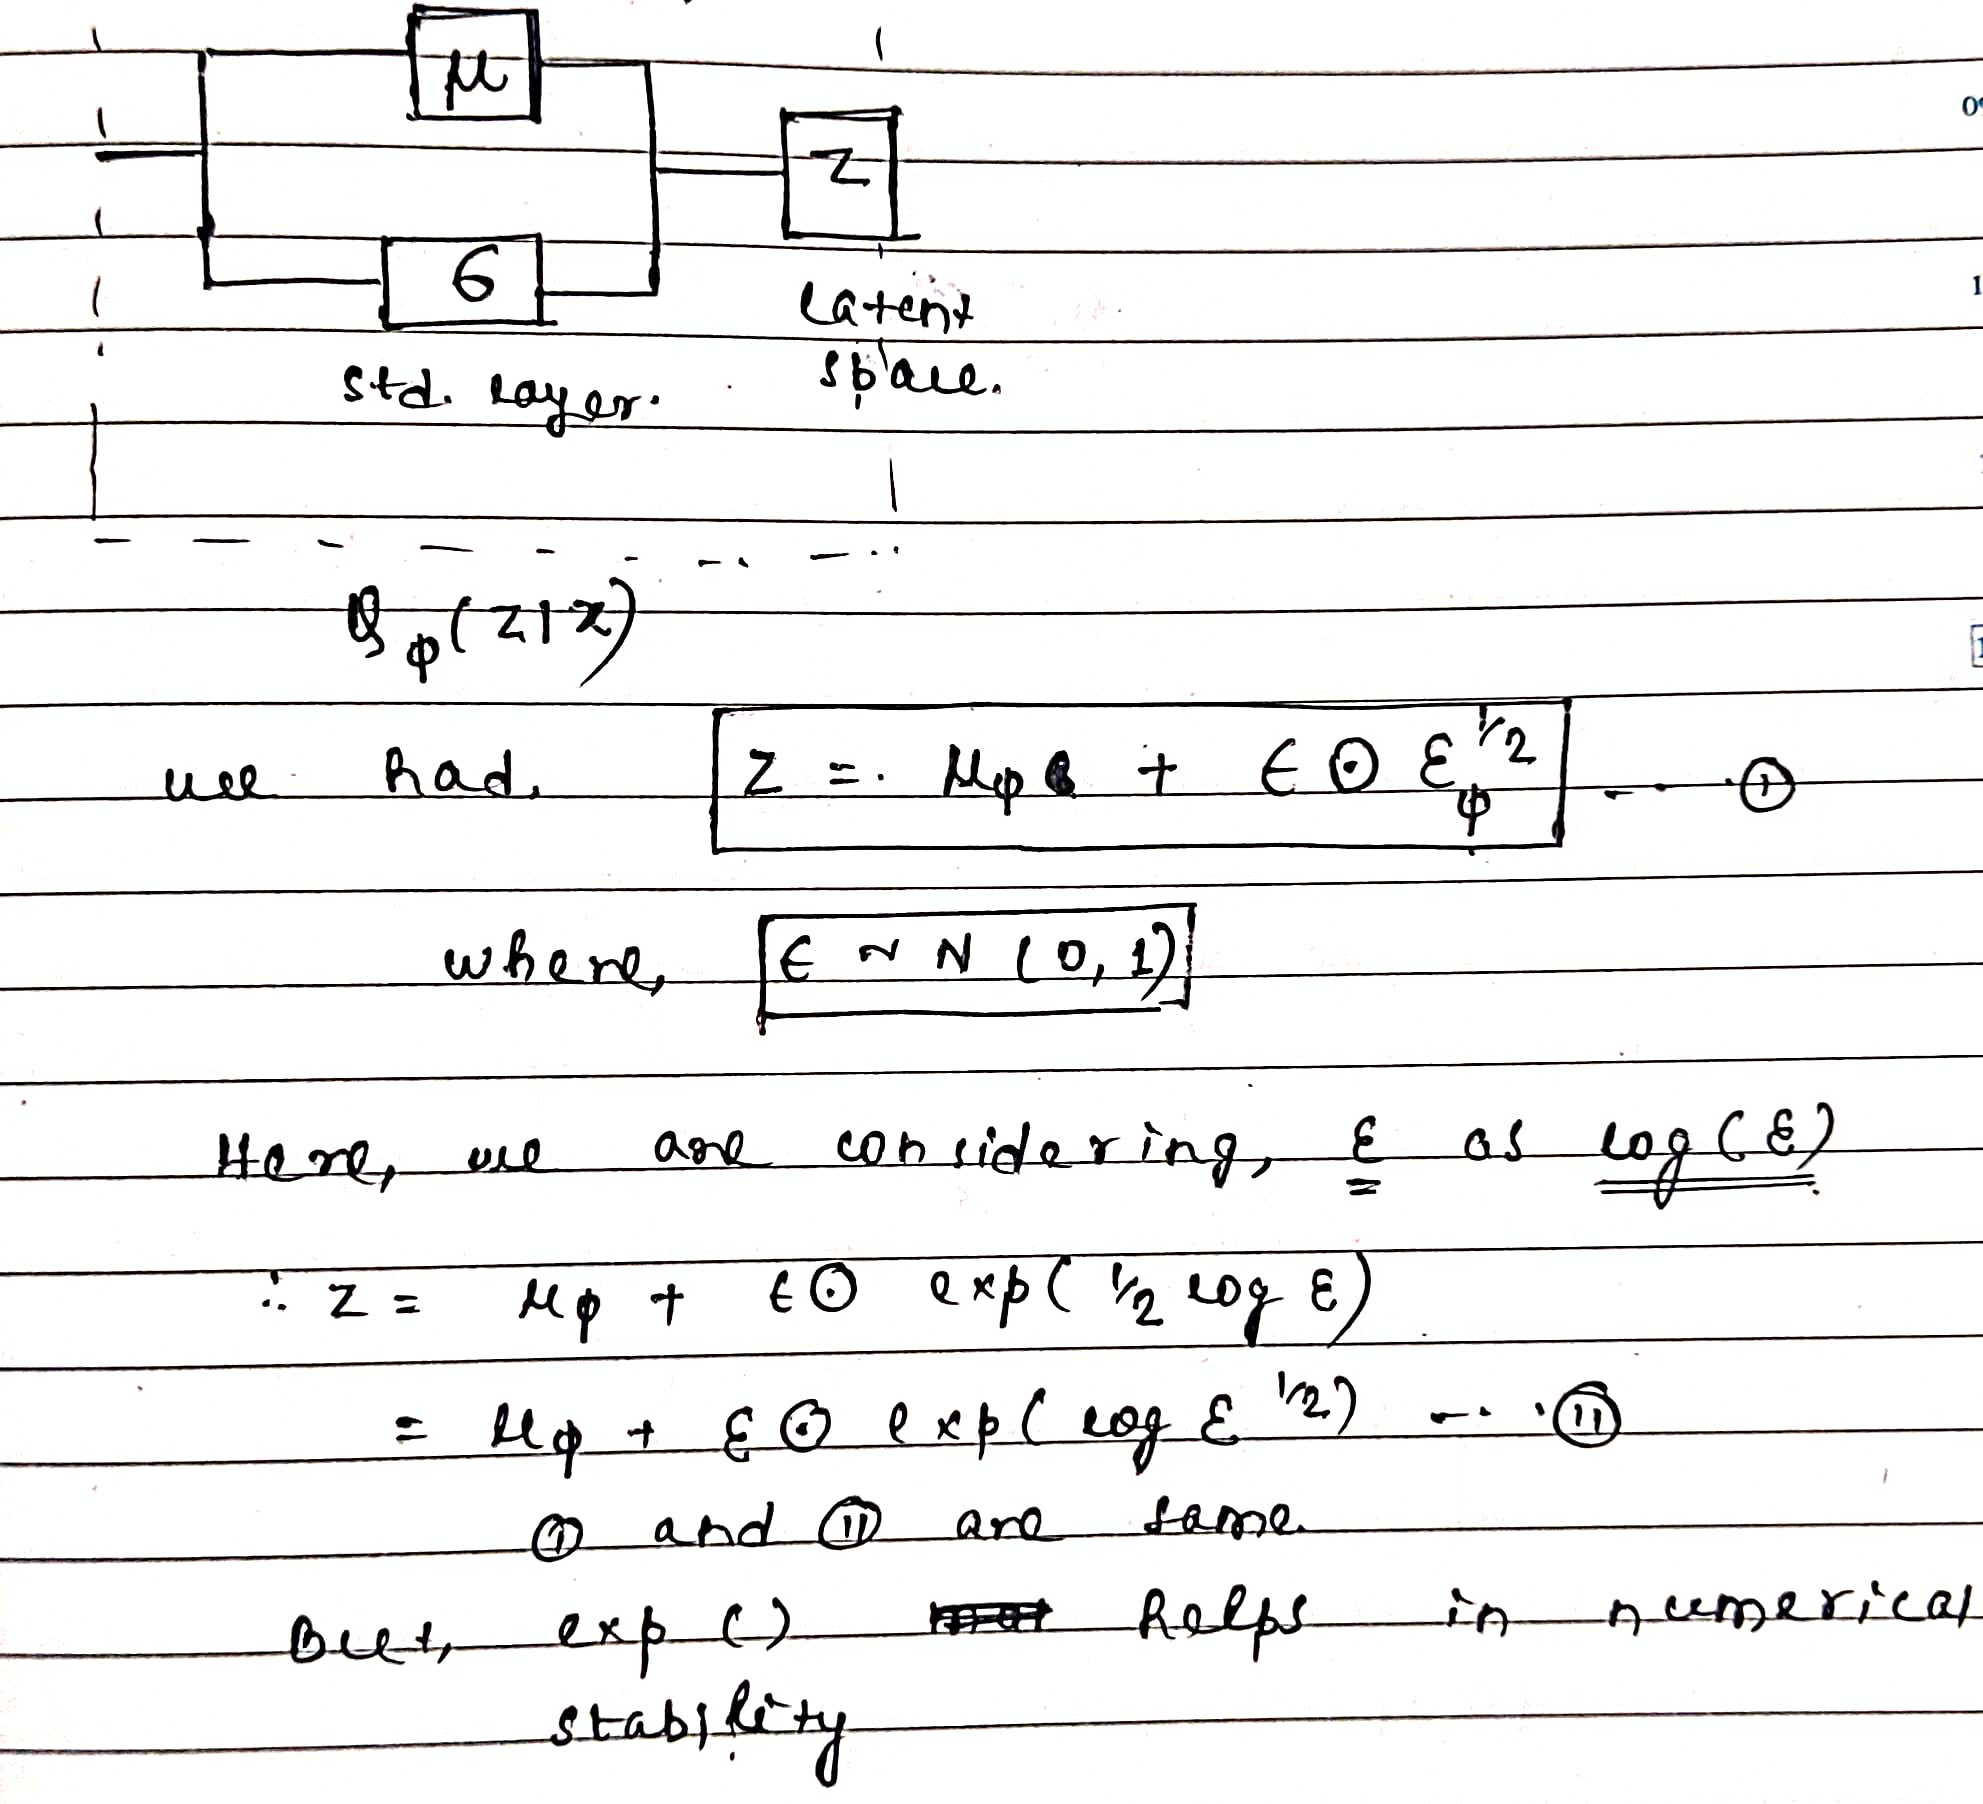


In [10]:
# defining the random samples from the rnormal distribution
epsilon = tf.random.normal(shape = tf.shape(std_layer), dtype = tf.float32, mean = 0.0, stddev = 1.0)
# defining the latent layer, which is the result of simple reparameterization trick to make the reconstruction loss a close loop
# it also helps to calculate the gradient following the monte-carlo integration
latent_layer = mean_layer + tf.exp(0.5*std_layer)*epsilon

## Decoder section

In [14]:
# defining the decoder hidden layer
decoder_hidden = tf.add(tf.matmul(latent_layer, weight["weight_matrix_decoder_hidden"]), bias["bias_matrix_decoder_hidden"])
decoder_hidden = tf.nn.tanh(decoder_hidden)

# defining the decoder output layer
decoder_output = tf.add(tf.matmul(decoder_hidden, weight["weight_matrix_decoder_output"]), bias["bias_matrix_decoder_output"])
decoder_output = tf.nn.sigmoid(decoder_output)

# Defining the Variational Lower Bound of the VAE

We know, **variational lower bound = Reconstructional loss or log-likelihood or data-fidelity_loss term + KL divergence term or the regularizer**

In [15]:
def variational_lower_bound(original_image, reconstructed_image):
  
  # as we are using log likelihood, the concern is attrivute of log != 0
  # so we are using a numerical stabilizer
  num_stabilizer = 1e-10

  # reconstruction loss
  data_fidelity_loss = original_image * tf.log(num_stabilizer + reconstructed_image) + (1 - original_image)*tf.log(1 + num_stabilizer - reconstructed_image)
  # summing all the loss corresponding to all the datapoints
  # if axis = None, all the elemnets in the data_fidelity term will be summed up-to a single element
  data_fidelity_loss =  -tf.reduce_mean(data_fidelity_loss, 1)